# This is a boosting tree version template for classification. <br>
You may simply change the loss functions to transfer it to regression model,<br>
and before that, you need to change lgb.LGBMClassifier to lgb.LGBMRegressor in lgb,<br>
and xgb.XGBRFClassifier to xgb.XGBRFRegressor in xgb.

In [4]:
import numpy as np
import datetime
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import skopt
# !pip install scikit-optimize if  necessary
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer

import warnings
warnings.simplefilter("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# data loading

In [2]:
data = np.random.rand(10000,31)
df = pd.DataFrame(data,columns = ['f'+str(i) for i in range(1,32)])
df['f31'] = df['f31'].apply(round)
df.loc[:7000,'f1'] = '2019-01-01'
df.loc[7000:,'f1'] = '2020-01-01'

# data cleansing

In [3]:

def data_cleansing(df):
    
    #df = df[conditions]     
    
    df = df.fillna(0)
    
    return df

print('clean data')
df_cleansed = data_cleansing(df)    

clean data


# data processing

In [4]:
dummy_features = []
date_features = ['f1']
norm_features = []
# normally we don't have to normalize data in boosting tree methods


def data_processing(df):
    
    if len(dummy_features) != 0:
        for feature in dummy_features:
            dummy = pd.get_dummies(df[feature],prefix=feature)
            df = pd.concat([df,dummy],axis=1)
        df = df.drop(columns = dummy_features)


    if len(date_features) != 0:
        for feature in date_features:
            df[feature+'_dayofweek'] = pd.to_datetime(df[feature]).dt.dayofweek
    
    #normally, normalization is subtle, not just compute mean and std of the whole dataset,
    #it may be different in different dataset. 
    
    #if len(norm_features) != 0:
        
    return df


print('process data')
df_processed = data_processing(df_cleansed)


process data


In [5]:
df_processed.columns

Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11',
       'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21',
       'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31',
       'f1_dayofweek'],
      dtype='object')

# data split

In [6]:
features = ['f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11',
       'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21',
       'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30','f1_dayofweek']
label = 'f31'
split_date = '2020-01-01'

def data_split(df,features,label,split_date):
    
    X_train = df[df['f1']<split_date][features].reset_index(drop=True)
    y_train = df[df['f1']<split_date][label].reset_index(drop=True)
    
    X_test = df[df['f1']>=split_date][features].reset_index(drop=True)
    y_test = df[df['f1']>=split_date][label].reset_index(drop=True)
    
    return X_train,y_train,X_test,y_test


X_train,y_train,X_test,y_test = data_split(df_processed,features,label,split_date)

# train model

In [7]:

def train_model(X_train,y_train,max_depth=6,learning_rate=0.1,n_estimators=200,
                num_leaves = 40,objective='regression_l1',boosting_type='gbdt'):

    gbm = lgb.LGBMClassifier(max_depth=max_depth,
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            objective=objective,
                            num_leaves=num_leaves,
                            boosting_type = boosting_type,
                            silent=False
                           )
    gbm.fit(X_train, y_train)
    return gbm

In [8]:
model = train_model(X_train,y_train)
y_pred = model.predict_proba(X_test)[:,1]




# Evaluate model

In [12]:
def plot_roc_curve(fpr,tpr,roc_auc):    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()



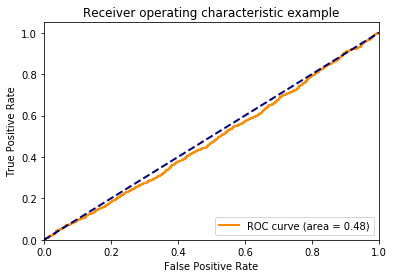

In [13]:
def evaluate_model(y_test,y_pred,PLOT=True):

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    if PLOT:
        plot_roc_curve(fpr,tpr,roc_auc)
    return roc_auc

AUC = evaluate_model(y_test,y_pred)

In [186]:
def PrecisionRecall(y_test,y_pred,threshold):
   
    y_pred = pd.DataFrame(y_pred,columns=['pred'])
    y_pred = y_pred['pred'].apply(lambda x: 1 if x>=threshold else 0)
    tp = pd.concat([y_test,y_pred],axis=1)
    tp.columns = ['true','pred']
    precision = tp[(tp['pred']==1)&(tp['true']==1)].shape[0]/tp[tp['pred']==1].shape[0]
    recall = tp[(tp['pred']==1)&(tp['true']==1)].shape[0]/tp[tp['true']==1].shape[0]
    return round(precision,4),round(recall,4)
    

In [188]:
Precision,Recall = PrecisionRecall(y_test,y_pred,0.5)
Precision,Recall

(0.4851, 0.3422)

# self define loss function

In [65]:
def custom_asymmetric_train(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -2*10.0*residual, -2*residual)
    hess = np.where(residual<0, 2*10.0, 2.0)
    return grad, hess


In [133]:
def binary_focal_loss(y_true,y_pred):
    alpha1 = 0.6
    alpha2 = 0.4
    gamma1 = 3
    gamma2 = 2

    
    grad = alpha1*np.power(1-y_pred,gamma1-1)*y_true*(y_pred+gamma1*y_pred*np.log(y_pred)-1) \
           - alpha2*np.power(y_pred,gamma2-1)*(y_true-1)*(y_pred+gamma2*(y_pred-1))*np.log(1-y_pred)/(1-y_pred)\
           
    hess = alpha1*np.power(1-y_pred,gamma1)/y_pred/y_pred + 2*gamma1*alpha1*np.power(1-y_pred,gamma1-1)*y_true/y_pred \
           - (gamma1-1)*gamma1*alpha1*np.power(1-y_pred,gamma1-2)*y_pred*np.log(y_pred) \
           + alpha2*np.power(y_pred,gamma2)*(1-y_true)/(1-y_pred)/(1-y_pred) \
           + 2*gamma2*alpha2*np.power(y_pred,1-gamma2)*(1-y_true)/(1-y_pred) \
           - (gamma2-1)*gamma2*alpha2*np.power(y_pred,gamma2-2)*(1-y_true)*np.log(1-y_pred)\
           
    return grad,hess





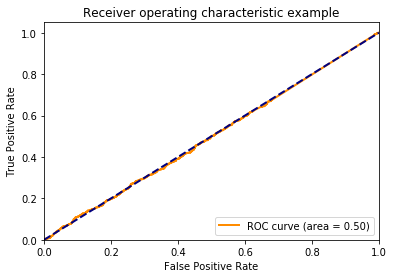

In [138]:
model = xgb.XGBRFClassifier(max_depth=6,
                            learning_rate=0.01,
                            n_estimators=60,
                            objective=binary_focal_loss,
                           )
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:,1]
AUC = evaluate_model(y_test,y_pred)


# BayesianOptization

In [196]:


max_depth = Integer(low=4, high=10, name='max_depth')
learning_rate = Real(low=1e-4,high=1e-1,name="learning_rate")
n_estimators = Integer(low=50, high=300, name='n_estimators')
num_leaves = Integer(low=20, high=50, name='num_leaves')
objective = Categorical(['regression_l1','tweedie'],name='objective')

dimensions = [
    max_depth,
    learning_rate,
    n_estimators,
    num_leaves,
    objective,
]

In [1]:
def fitness(dimensions):
    model = train_model(X_train,y_train,max_depth=dimensions[0],learning_rate=dimensions[1],n_estimators=dimensions[2],
                num_leaves = dimensions[3],objective=dimensions[4],)
    y_pred = model.predict_proba(X_test)[:,1]
    AUC = evaluate_model(y_test,y_pred,PLOT=False)

    return round(AUC,4)
    
default_parameters = [6,0.1,100,40,'regression_l1']
gp_result = gp_minimize(func=fitness,dimensions=dimensions,verbose=True,n_jobs=4,n_calls=30,x0=default_parameters)
params = []
params.append(gp_result.x)